TV-Regularized Sparse-View CT Reconstruction (Multiple Projectors)
==================================================================

This example demonstrates solution of a sparse-view CT reconstruction
problem with isotropic total variation (TV) regularization

  $$\mathrm{argmin}_{\mathbf{x}} \; (1/2) \| \mathbf{y} - A \mathbf{x}
  \|_2^2 + \lambda \| C \mathbf{x} \|_{2,1} \;,$$

where $A$ is the X-ray transform (the CT forward projection operator),
$\mathbf{y}$ is the sinogram, $C$ is a 2D finite difference operator, and
$\mathbf{x}$ is the desired image. The solution is computed and compared
for all three 2D CT projectors available in scico.

In [1]:
import numpy as np

from xdesign import Foam, discrete_phantom

import scico.numpy as snp
from scico import functional, linop, loss, metric, plot
from scico.linop.xray import Parallel2dProjector, XRayTransform, astra, svmbir
from scico.optimize.admm import ADMM, LinearSubproblemSolver
from scico.util import device_info
plot.config_notebook_plotting()

Create a ground truth image.

In [2]:
N = 512  # phantom size
np.random.seed(1234)
x_gt = snp.array(discrete_phantom(Foam(size_range=[0.075, 0.0025], gap=1e-3, porosity=1), size=N))

Define CT geometry and construct array of (approximately) equivalent projectors.

In [3]:
n_projection = 45  # number of projections
angles = np.linspace(0, np.pi, n_projection)  # evenly spaced projection angles
projectors = {
    "astra": astra.XRayTransform2D(x_gt.shape, N, 1.0, angles - np.pi / 2.0),  # astra
    "svmbir": svmbir.XRayTransform(x_gt.shape, 2 * np.pi - angles, N),  # svmbir
    "scico": XRayTransform(Parallel2dProjector((N, N), angles, det_count=N)),  # scico
}

Solve the same problem using the different projectors.

In [4]:
print(f"Solving on {device_info()}")
y, x_rec, hist = {}, {}, {}
noise = np.random.normal(size=(n_projection, N)).astype(np.float32)
for p in ("astra", "svmbir", "scico"):
    print(f"\nSolving with {p} projector")
    A = projectors[p]
    y[p] = A @ x_gt + 2.0 * noise  # sinogram

    # Set up ADMM solver object.
    λ = 2e0  # L1 norm regularization parameter
    ρ = 5e0  # ADMM penalty parameter
    maxiter = 25  # number of ADMM iterations
    cg_tol = 1e-4  # CG relative tolerance
    cg_maxiter = 25  # maximum CG iterations per ADMM iteration

    # The append=0 option makes the results of horizontal and vertical
    # finite differences the same shape, which is required for the L21Norm,
    # which is used so that g(Cx) corresponds to isotropic TV.
    C = linop.FiniteDifference(input_shape=x_gt.shape, append=0)
    g = λ * functional.L21Norm()
    f = loss.SquaredL2Loss(y=y[p], A=A)
    x0 = snp.clip(A.T(y[p]), 0, 1.0)

    # Set up the solver.
    solver = ADMM(
        f=f,
        g_list=[g],
        C_list=[C],
        rho_list=[ρ],
        x0=x0,
        maxiter=maxiter,
        subproblem_solver=LinearSubproblemSolver(cg_kwargs={"tol": cg_tol, "maxiter": cg_maxiter}),
        itstat_options={"display": True, "period": 5},
    )

    # Run the solver.
    solver.solve()
    hist[p] = solver.itstat_object.history(transpose=True)
    x_rec[p] = snp.clip(solver.x, 0, 1.0)

Solving on GPU (NVIDIA GeForce RTX 2080 Ti)

Solving with astra projector


Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  3.24e+00  6.066e+03  1.208e+02  3.581e+00     25  7.770e-04


   5  1.13e+01  3.211e+04  3.984e+01  7.781e+01     18  9.753e-05


  10  1.45e+01  3.552e+04  2.381e+01  1.547e+01      0  9.522e-05


  15  1.75e+01  3.650e+04  2.933e+01  3.780e+01     13  9.580e-05


  20  1.90e+01  3.669e+04  9.308e+00  3.812e+00      0  9.810e-05


  24  1.98e+01  3.690e+04  8.112e+00  3.185e+00      0  7.889e-05

Solving with svmbir projector


Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  1.90e+01  5.671e+03  1.249e+02  5.708e+00     25  4.341e-04


   5  1.04e+02  3.272e+04  3.791e+01  8.424e+01     16  7.794e-05


  10  1.43e+02  3.662e+04  2.992e+01  5.590e+01     15  9.741e-05


  15  1.77e+02  3.719e+04  1.295e+01  2.983e+01     11  9.084e-05


  20  1.94e+02  3.758e+04  1.129e+01  5.027e+00      1  6.963e-05


  24  2.00e+02  3.793e+04  1.018e+01  4.801e+00      0  9.264e-05

Solving with scico projector


Iter  Time      Objective  Prml Rsdl  Dual Rsdl  CG It  CG Res   
-----------------------------------------------------------------
   0  2.53e-01  8.946e+03  1.226e+02  1.362e+01     25  4.222e-04


   5  6.71e-01  3.298e+04  4.269e+01  7.752e+01     15  9.399e-05


  10  9.24e-01  3.633e+04  3.167e+01  4.602e+01     13  9.149e-05
  15  1.08e+00  3.699e+04  3.064e+01  7.302e+01     16  9.570e-05


  20  1.26e+00  3.690e+04  1.934e+01  3.107e+01     13  8.947e-05


  24  1.38e+00  3.704e+04  1.504e+01  2.453e+01     11  8.575e-05


Compare sinograms.

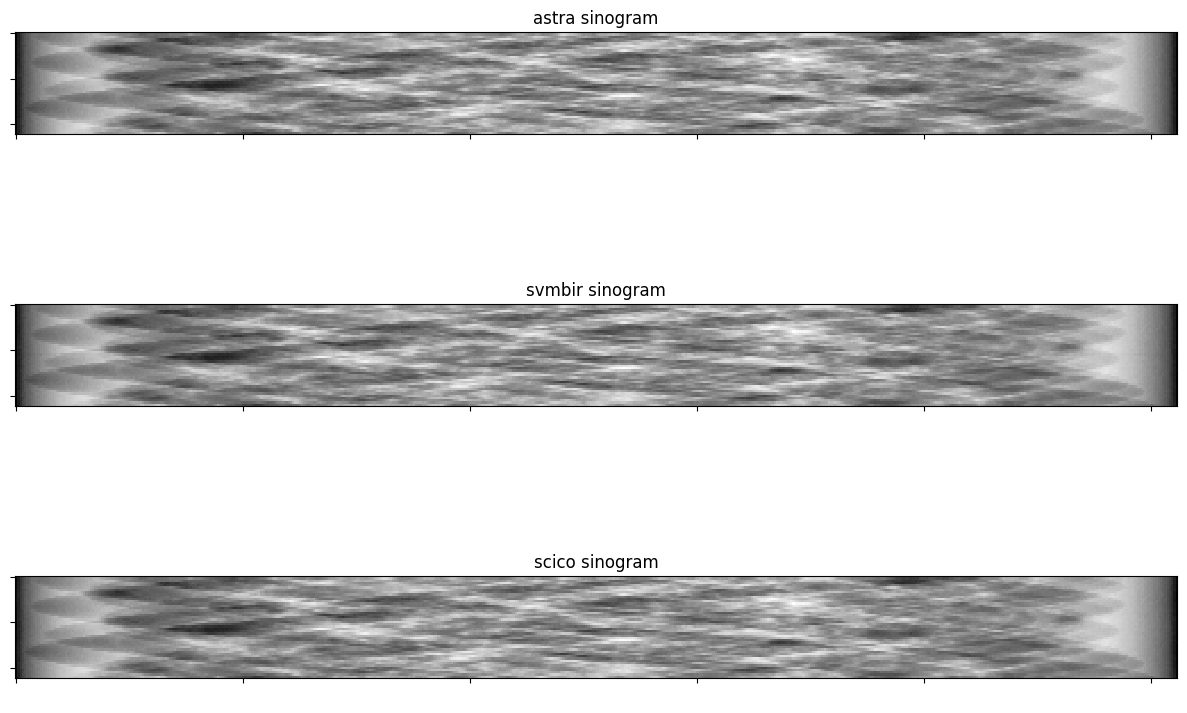

In [5]:
fig, ax = plot.subplots(nrows=3, ncols=1, figsize=(15, 10))
for idx, name in enumerate(projectors.keys()):
    plot.imview(y[name], title=f"{name} sinogram", cbar=None, fig=fig, ax=ax[idx])
fig.show()

Plot convergence statistics.

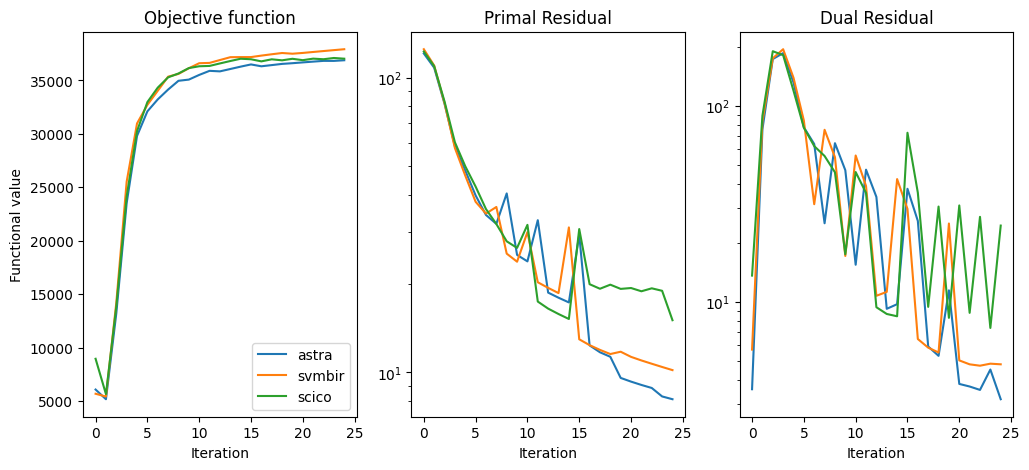

In [6]:
fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(12, 5))
plot.plot(
    np.vstack([hist[p].Objective for p in projectors.keys()]).T,
    title="Objective function",
    xlbl="Iteration",
    ylbl="Functional value",
    lgnd=projectors.keys(),
    fig=fig,
    ax=ax[0],
)
plot.plot(
    np.vstack([hist[p].Prml_Rsdl for p in projectors.keys()]).T,
    ptyp="semilogy",
    title="Primal Residual",
    xlbl="Iteration",
    fig=fig,
    ax=ax[1],
)
plot.plot(
    np.vstack([hist[p].Dual_Rsdl for p in projectors.keys()]).T,
    ptyp="semilogy",
    title="Dual Residual",
    xlbl="Iteration",
    fig=fig,
    ax=ax[2],
)
fig.show()

Show the recovered images.

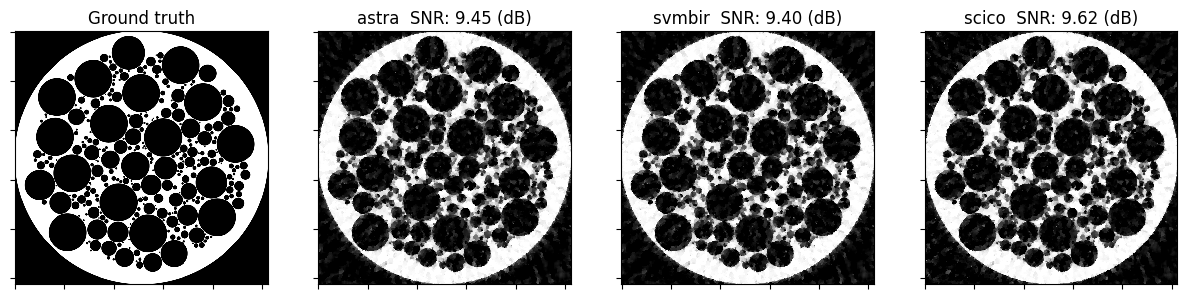

In [7]:
fig, ax = plot.subplots(nrows=1, ncols=4, figsize=(15, 5))
plot.imview(x_gt, title="Ground truth", fig=fig, ax=ax[0])
for n, p in enumerate(projectors.keys()):
    plot.imview(
        x_rec[p],
        title="%s  SNR: %.2f (dB)" % (p, metric.snr(x_gt, x_rec[p])),
        fig=fig,
        ax=ax[n + 1],
    )
fig.show()